<a href="https://colab.research.google.com/github/Shonn-Li/CS484-final-project/blob/main/CS484.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# libraries
import random
import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt
from typing import OrderedDict
from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 1: Prepare data
We will use CIFAR10 dataset.

In [2]:
# define transform
caltech256_all = datasets.Caltech256(root="./data", download=True, transform=transforms.ToTensor())

# only use a subset of image for experiment
subset_size = 2000 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!change this later!!!!!!!!!!!!!!!!!!!!!!!
random_indices = random.sample(range(len(caltech256_all)), subset_size)
caltech256_subset = Subset(caltech256_all, random_indices)

# filter out images that do not have 3 channels
def is_three_channel(idx):
    image, _ = caltech256_subset[idx]
    return image.size(0) == 3
valid_indices = [idx for idx in range(len(caltech256_subset)) if is_three_channel(idx)]
caltech256_filtered = Subset(caltech256_subset, valid_indices)

# img transform
norms = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
trainTrans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(*norms)
])

# class for applying transformations
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# apply transformations to the filtered dataset
caltech256 = TransformDataset(caltech256_filtered, transform=trainTrans)



1183006720it [00:19, 61828239.30it/s] 


Extracting ./data/caltech256/256_ObjectCategories.tar to ./data/caltech256


In [3]:
print(f"processed dataset size: {len(caltech256)}")

processed dataset size: 1972


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


image label: 73
torch.Size([3, 224, 224])


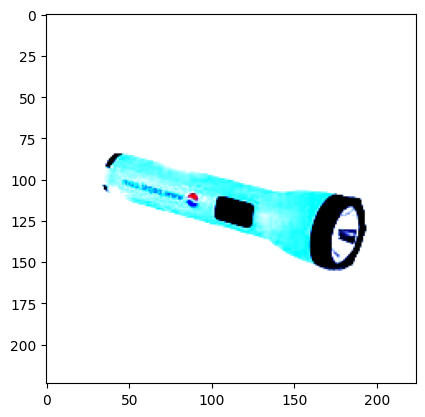

In [4]:
img, label = caltech256[50]
print(f"image label: {label}")
plt.figure()
plt.imshow(torch.permute(img, (1, 2, 0)))
print(img.shape)

### Step 2: Define Network

In [5]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()

        # extract vgg19 feature layer
        vgg19 = models.vgg19(weights='DEFAULT')
        self.vgg19Feat = vgg19.features[:28] # result in 512x14x14
        for param in self.vgg19Feat.parameters():
            param.requires_grad = False

        # additional conv layer & average pooling
        self.process = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
            ('pool', nn.AdaptiveAvgPool2d((1, 1))),
            ('flatten', nn.Flatten()),
            ('linear', nn.Linear(1024, num_classes))
        ]))


    def forward(self, x):
        x = self.vgg19Feat(x)
        x = self.process(x)

        return x

### Step 3: Training

In [6]:
# training function
def trainLoop(model, criterion, optimizer, dataloader, max_epoch):
    losses = []
    accuracies = []
    model.train()
    for epoch in range(max_epoch):
        epoch_loss = 0
        epoch_correct = 0
        dataCount = 0
        for images, labels in dataloader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = outputs.max(dim=1)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            dataCount += images.size(0)

            epoch_correct += torch.eq(preds, labels).sum().item()

            loss.backward()
            optimizer.step()

        # gather loss
        epoch_avg_loss = epoch_loss / dataCount
        epoch_acc = epoch_correct / dataCount
        losses.append(epoch_avg_loss)
        accuracies.append(epoch_acc)
        print(f"Epoch {epoch + 1}， loss is {epoch_avg_loss:.3f}, accuracy is {epoch_acc:.3f}")

    return losses, accuracies

In [7]:
# split data into test and training sets
train_size = int(0.8 * len(caltech256))
test_size = len(caltech256) - train_size
train_dataset, test_dataset = random_split(caltech256, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# perform training
model = MyModel(257).to(device)
criterion = nn.CrossEntropyLoss()
parameters = [{'params': model.process.parameters()}]
optimizer = optim.Adam(parameters, lr=0.001)
max_epoch=8
train_loss, train_acc = trainLoop(model, criterion, optimizer, train_loader,  max_epoch)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 137MB/s]


Epoch 1， loss is 0.313, accuracy is 0.096
Epoch 2， loss is 0.113, accuracy is 0.401
Epoch 3， loss is 0.067, accuracy is 0.555
Epoch 4， loss is 0.053, accuracy is 0.644
Epoch 5， loss is 0.044, accuracy is 0.725
Epoch 6， loss is 0.034, accuracy is 0.773
Epoch 7， loss is 0.032, accuracy is 0.798
Epoch 8， loss is 0.029, accuracy is 0.808


### Step 4: Create CAM

In [15]:
class CAM(nn.Module):
  def __init__(self, model):
    super(CAM, self).__init__()
    self.weights = list(model.process.linear.parameters())[0]
    self.feature_layers = nn.Sequential(model.vgg19Feat, model.process.conv)

    for params in self.feature_layers.parameters():
      params.requires_grad = False

  def forward(self, imgs, categories):
    feat_weights = self.weights[categories].unsqueeze(-1).unsqueeze(-1)
    feat_maps= self.feature_layers(imgs)

    cam = torch.sum(feat_weights * feat_maps, dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, imgs.shape[2:], mode='bilinear', align_corners=False)

    cam = cam - cam.min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0]
    cam = cam / cam.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0]

    return cam




In [13]:
def createCAM(model, dataset, demoTransform, inputTransform,
              CustomTransform=TransformDataset, batch_size=32):
  camModel = CAM(model)
  inputData = CustomTransform(dataset, inputTransform)
  demoData = CustomTransform(dataset, demoTransform)
  inputLoader = DataLoader(inputData, batch_size, shuffle=False)
  demoLoader = DataLoader(demoData, batch_size, shuffle=False)

  heatmaps = []
  demoImages = []

  with torch.no_grad():
    for (inputImgs, labels), (demoImgs, _) in zip(inputLoader, demoLoader):
      heatImg = camModel(inputImgs.to(device), labels.to(device))

      heatmaps.append(heatImg.cpu())
      demoImages.append(demoImgs)

    resultHeatMaps = torch.cat(heatmaps, dim=0)
    resultDemoImages = torch.cat(demoImages, dim=0)

    return resultHeatMaps, resultDemoImages



In [16]:
demoTrans = transforms.Compose(
    [transforms.Resize((224, 224))]
)
inputTrans = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.Normalize(*norms)]
)
indicies = [i for i in range(40, 51, 1)]
caltech256_sub = Subset(caltech256_filtered, indicies)
heatMaps, oriImgs = createCAM(model, caltech256_sub, demoTrans, inputTrans)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [17]:
heatMaps.shape

torch.Size([11, 1, 224, 224])

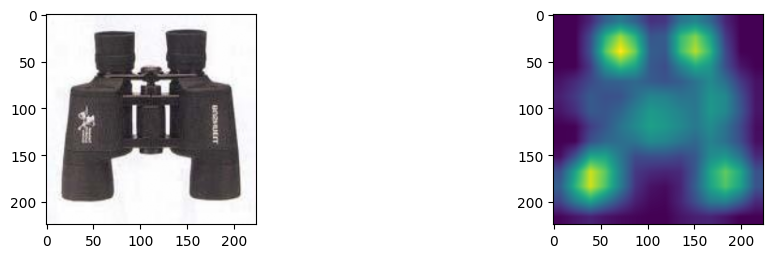

In [18]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(oriImgs[0].permute(1, 2, 0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(heatMaps[0].permute(1, 2, 0))

### TODO
- Adjust output layer to generate binary output for target class (e.g. face or nor face)
- Identify correctly classified & miss classified picture
- Write function to generate heat map for correctly identified picture
- Implement "object localization"
